# Deep Hedging [Finance & Machine Learning 2021/22]

## Authors: Jonathan Baker, Juraj Zelman

In [53]:
import numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns, matplotlib as mpl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
from tqdm import tqdm

# Import from Classes
from Classes.hestonModelGenerator import hestonGenerator
from Classes.bsModelGenerator import bsGenerator

In [54]:
# Parameters

N  = 100  # time disrectization
S0 = 1    # initial value of the asset
K  = 1    # strike for the call option 
T  = 1.0  # maturity (years)
sig = 0.3 # volatility in Black Scholes

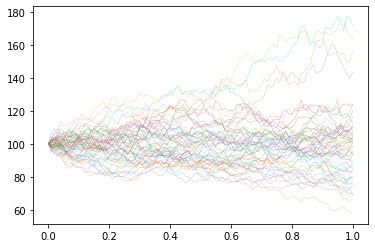

In [55]:
# Generate Black-Scholes trajectories
batchSize = 50

for S in bsGenerator(batchSize = batchSize):
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,100+1), S[i,:], alpha = 0.5, linewidth = 0.4)
plt.show()

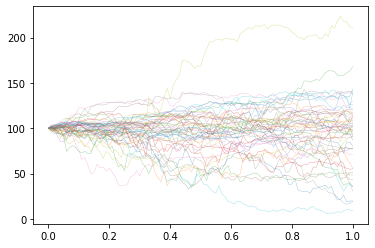

In [56]:
# Generate Heston model trajectories
batchSize = 50

for S in hestonGenerator(batchSize = batchSize):
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,100 + 1), S[i,:], alpha = 0.5, linewidth = 0.4)
plt.show()

## Train the Neural Network

In [57]:
class Strategy(nn.Module):
    def __init__(self, hidden_nodes, no_time_steps):
        super(Strategy, self).__init__()
        
        # set the price pthe claim
        self.cap = nn.Parameter(torch.tensor(0, dtype=torch.float32))
        
        # Neural network architecture
        self.steps = nn.ModuleList()
        for i in range(no_time_steps):
            h_i = nn.Sequential(
                nn.Linear(1, hidden_nodes),
                nn.ReLU(),
                nn.Linear(hidden_nodes, hidden_nodes),
                nn.ReLU(),
                nn.Linear(hidden_nodes, 1)
            )
        self.steps.append(h_i)
        
    def forward(self, x):
        # x denotes minibatch of stock price processes
        dS = torch.diff(x)
        ret = torch.zeros_like(dS[:,0]) + self.cap
        
        for i in range(len(self.steps)):
            logS = torch.log(x[:,1])
            h_i = self.steps[i]
            H_i = h_i(logS.unsqueeze(-1))
            ret += dS[:, i] * H_i.flatten()
        return ret

In [58]:
# Neural network initialization
no_time_steps = 22
strategy = Strategy(100, no_time_steps)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(strategy.parameters(), lr=0.01)
def claim(x):
    return torch.max(x, S0*torch.ones_like(x)) - S0



100it [00:07, 12.81it/s]


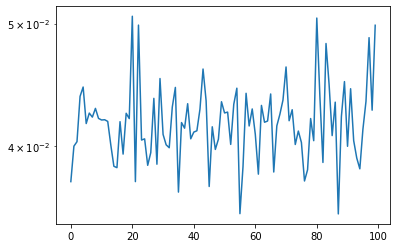

In [61]:
errors = []
#for S in tqdm(bsGenerator(numBatches=50, batchSize = 2000)):
for S in tqdm(hestonGenerator(S0 = S0, numBatches=100, batchSize = 2000)):
    optimizer.zero_grad()
    err = loss(strategy(S), claim(S[:, -1]))
    errors.append(err.item())
    err.backward()
    optimizer.step()
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(errors))
plt.show()
    

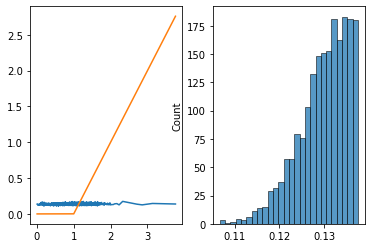

In [64]:
x = torch.linspace(0,20,100)
fig, ax = plt.subplots(1,2)
with torch.no_grad():
    sns.histplot(strategy(S) - claim(S[:,1]), ax = ax[1])
    sns.lineplot(x = S[:, -1], y = strategy(S), ax = ax[0])
    sns.lineplot(x = S[:, -1], y = claim(S[:, -1]), ax = ax[0])
plt.show()